In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/My Drive/colab/ImageStyleTransfer")

In [3]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
# 设置图片大小为512
imsize = 512 #if torch.cuda.is_available() else 128   # cpu下设置大小为128

loader = transforms.Compose([
    transforms.Resize([imsize, imsize]),    # 调整图片尺寸
    transforms.ToTensor()])   # 把图片转为tensor


def image_loader(image_name):
    image = Image.open(image_name)

    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# 加载两张风格图
# style_img1 = image_loader("style/mosaic.jpg")
# style_img2 = image_loader("style/style_5.jpg")

style_img1 = image_loader("style/feathers.jpg")
# style_img2 = image_loader("style/candy.jpg")
style_img2 = image_loader("style/mosaic.jpg")
 
content_img = image_loader("content/test.jpg")

print(style_img1.size())
print(content_img.size())


assert style_img1.size() == content_img.size(), \
    "style尺寸和content尺寸不一致"

torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


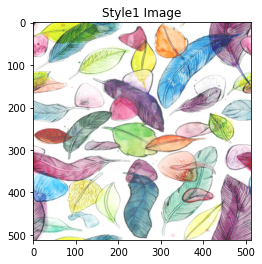

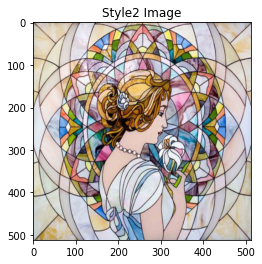

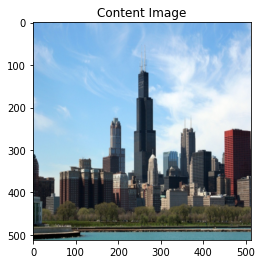

In [6]:
unloader = transforms.ToPILImage()  # 把tensor转为图片

plt.ion()

# 显示图片
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


plt.figure()
imshow(style_img1, title='Style1 Image')
plt.figure()
imshow(style_img2, title='Style2 Image')
plt.figure()
imshow(content_img, title='Content Image')


In [7]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # 把contentloss接在vgg19的某一层后面，并且detach掉，
        # 因为只用到vgg提取特征，在训练的时候不需要更新vgg的参数
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [8]:
def gram_matrix(input):
    # a=batch size
    # b=通道数
    # (c,d)=图片尺寸w，h
    a, b, c, d = input.size()  
    
    # 把inputresize成二维
    # 行代表 batchsize * 通道数
    # 列代表 图片 w * h
    features = input.view(a * b, c * d) 
    
    G = torch.mm(features, features.t())#矩阵想乘

    return G.div(a * b * c * d)

In [9]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature1,target_feature2):
        super(StyleLoss, self).__init__()
        # 初始化输入两张风格图，分别计算loss1和loss2
        self.target1 = gram_matrix(target_feature1).detach()
        self.target2 = gram_matrix(target_feature2).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss1 = F.mse_loss(G, self.target1)
        self.loss2 = F.mse_loss(G, self.target2)
        return input

In [10]:
# 下载vgg19
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [11]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# 标准化
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # 对图片的值标准化，对应tensor的3，4维
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [12]:
# 从vgg19的conv_4提供内容特征
content_layers_default = ['conv_4']
# 从vgg19的conv_1, conv_2, conv_3, conv_4, conv_5提供风格特征
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img1, style_img2, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # 保存loss
    content_losses = []
    style_losses = []
    
    # test
    # mynet = Net().to(device)

    
    # model 用来从vgg中特征并计算损失
    model = nn.Sequential(normalization)

    # model.add_module('my_module', mynet)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            # 比较和两张和风格图的损失
            target_feature1 = model(style_img1).detach()
            target_feature2 = model(style_img2).detach()

            style_loss = StyleLoss(target_feature1, target_feature2)

            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # 在抽取特征时，我们只需要用到VGG从输入层到最靠近输出层的内容层或样式层之间的所有层
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

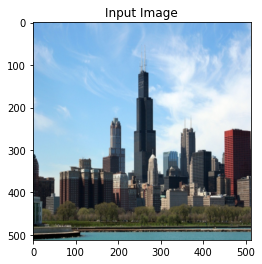

In [13]:
# 显示content图片
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')

In [14]:
# 获取优化器
def get_input_optimizer(input_img, lr=0.1):
    optimizer = optim.LBFGS([input_img.requires_grad_()], lr=lr)
    return optimizer

In [15]:
# 训练
def run_style_transfer(cnn, normalization_mean, normalization_std, content_img, style_img1, style_img2, input_img, lr=0.1, num_steps=300, style1_weight=10000, style2_weight=10000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img1, style_img2, content_img)
    
    optimizer = get_input_optimizer(input_img, lr)
    
    # optimizer = get_input_optimizer(input_img)
    # mynet = Net().to(device)

    # optimizer = optim.Adam(mynet.parameters())

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # 把值限制在0和1之间
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            # model(input_img)
            model(input_img)
            style_score1 = 0
            style_score2 = 0
            content_score = 0
            
            
            for sl in style_losses:
                style_score1 += sl.loss1
            
            for sl in style_losses:
                style_score2 += sl.loss2

            for cl in content_losses:
                content_score += cl.loss

            
            style_score1 *= style1_weight
            style_score2 *= style2_weight
            content_score *= content_weight
            loss = style_score1 + content_score + style_score2
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style1 Loss : {:4f} Style2 Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score1.item(), style_score2.item(), content_score.item()))
                print()

            return style_score1 + content_score + style_score2

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img


Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


run [50]:
Style1 Loss : 21.468876 Style2 Loss : 0.000000 Content Loss: 11.853584

run [100]:
Style1 Loss : 8.902189 Style2 Loss : 0.000000 Content Loss: 12.512070

run [150]:
Style1 Loss : 5.038537 Style2 Loss : 0.000000 Content Loss: 12.045425

run [200]:
Style1 Loss : 3.986549 Style2 Loss : 0.000000 Content Loss: 11.537302

run [250]:
Style1 Loss : 3.680321 Style2 Loss : 0.000000 Content Loss: 11.179795

run [300]:
Style1 Loss : 3.458525 Style2 Loss : 0.000000 Content Loss: 10.966520

run [350]:
Style1 Loss : 3.243686 Style2 Loss : 0.000000 Content Loss: 10.823599

run [400]:
Style1 Loss : 3.037705 Style2 Loss : 0.000000 Content Loss: 10.742558

run [450]:
Style1 Loss : 2.840239 Style2 Loss : 0.000000 Content Loss: 10.683563

run [500]:
Style1 Loss : 2.679163 Style2 Loss : 0.000000 Content Loss: 10.645126

run [550]:
Style1 Loss : 2.555746 Style2 Loss : 0.000000 Content Loss: 10.645678

run [600]:
Style1 Loss : 2.466749 Style2 Loss : 0.000000 Content Loss: 10.692577

run [650]:
Style

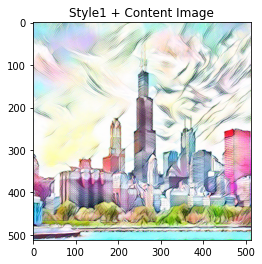

In [16]:

# 风格1 + 内容图
input_img = content_img.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img1, style_img2, input_img, num_steps=800, style2_weight=1e-5)

plt.figure()
imshow(output, title='Style1 + Content Image')

plt.ioff()
plt.show()

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


run [50]:
Style1 Loss : 0.000000 Style2 Loss : 70.487083 Content Loss: 21.086948

run [100]:
Style1 Loss : 0.000000 Style2 Loss : 17.638430 Content Loss: 24.505341

run [150]:
Style1 Loss : 0.000000 Style2 Loss : 5.337605 Content Loss: 22.738632

run [200]:
Style1 Loss : 0.000000 Style2 Loss : 3.161709 Content Loss: 21.285709

run [250]:
Style1 Loss : 0.000000 Style2 Loss : 2.654121 Content Loss: 20.495665

run [300]:
Style1 Loss : 0.000000 Style2 Loss : 2.453835 Content Loss: 20.017982

run [350]:
Style1 Loss : 0.000000 Style2 Loss : 2.353225 Content Loss: 19.692772

run [400]:
Style1 Loss : 0.000000 Style2 Loss : 2.293408 Content Loss: 19.442835

run [450]:
Style1 Loss : 0.000000 Style2 Loss : 2.245908 Content Loss: 19.266228

run [500]:
Style1 Loss : 0.000000 Style2 Loss : 2.213111 Content Loss: 19.145472

run [550]:
Style1 Loss : 0.000000 Style2 Loss : 2.201131 Content Loss: 19.062454

run [600]:
Style1 Loss : 0.000000 Style2 Loss : 2.802638 Content Loss: 18.952194

run [650]:
Styl

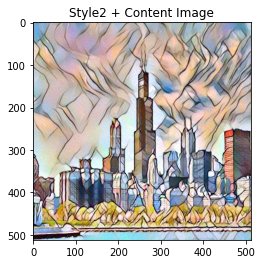

In [17]:
# 风格2 + 内容图
input_img = content_img.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img1, style_img2, input_img, num_steps=800, style1_weight=1e-5)

plt.figure()
imshow(output, title='Style2 + Content Image')

plt.ioff()
plt.show()

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


run [50]:
Style1 Loss : 54.838886 Style2 Loss : 104.144012 Content Loss: 17.150438

run [100]:
Style1 Loss : 49.197231 Style2 Loss : 58.899986 Content Loss: 20.033276

run [150]:
Style1 Loss : 46.146088 Style2 Loss : 50.793411 Content Loss: 18.841347

run [200]:
Style1 Loss : 45.516621 Style2 Loss : 49.598877 Content Loss: 17.598591

run [250]:
Style1 Loss : 45.361897 Style2 Loss : 49.211636 Content Loss: 16.921728

run [300]:
Style1 Loss : 45.258274 Style2 Loss : 49.024899 Content Loss: 16.510593

run [350]:
Style1 Loss : 45.159767 Style2 Loss : 48.909061 Content Loss: 16.215134

run [400]:
Style1 Loss : 45.061932 Style2 Loss : 48.831966 Content Loss: 15.987955

run [450]:
Style1 Loss : 44.944183 Style2 Loss : 48.806557 Content Loss: 15.806919

run [500]:
Style1 Loss : 44.840023 Style2 Loss : 48.795403 Content Loss: 15.668489

run [550]:
Style1 Loss : 44.742989 Style2 Loss : 48.803780 Content Loss: 15.554313

run [600]:
Style1 Loss : 44.678017 Style2 Loss : 48.787792 Content Loss: 15.

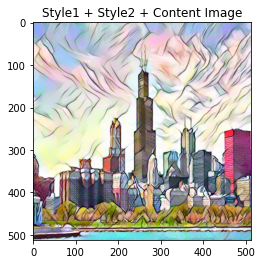

In [18]:
# 风格1 + 风格2 + 内容图
input_img = content_img.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img1, style_img2, input_img, num_steps=800)

plt.figure()
imshow(output, title='Style1 + Style2 + Content Image')

plt.ioff()
plt.show()

<PIL.Image.Image image mode=RGB size=512x512 at 0x7F4A902ABDD8>


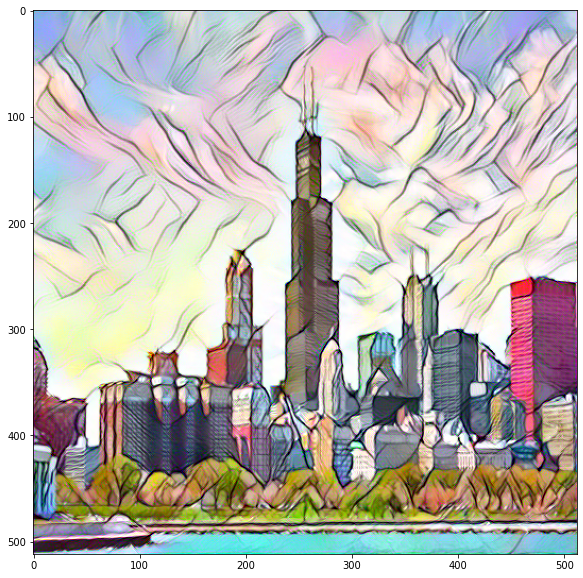

In [19]:
plt.figure(figsize=(10,10))
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

image = output.cpu().clone()
image = image.squeeze(0)
image = unloader(image)
plt.imshow(image)
print(image)

plt.show()

